In [1]:
import matplotlib.pyplot as plt
import csv
import datetime
import time

from IPython.display import clear_output
from DataSet import DataSet
from Circuit import Circuit
from qat.interop.qiskit import qlm_to_qiskit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


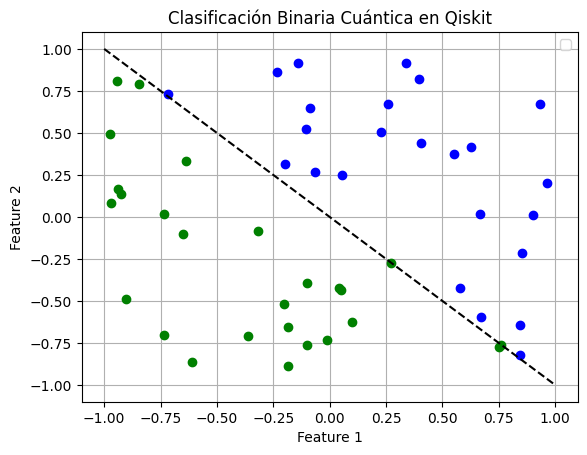

In [2]:
dataset = DataSet(seed=40)
dataset.Draw()

In [3]:
circuit = Circuit()
circuit.ZZFeatureMap()
circuit.varCircuit3()

circuit.display()

In [4]:
qlm_circuit = circuit.circuit()
qiskit_circuit = qlm_to_qiskit(qlm_circuit)
qiskit_circuit.remove_final_measurements()

qiskit_circuit.draw()

┌───┐┌──────────────────┐┌──────────────────┐     »
q0_0: ┤ H ├┤ Rz(2.0*varData0) ├┤ Rz(2.0*varData1) ├──■──»
      ├───┤└──────────────────┘└──────────────────┘┌─┴─┐»
q0_1: ┤ H ├────────────────────────────────────────┤ X ├»
      └───┘                                        └───┘»
«                                                    ┌───┐┌──────────────────┐»
«q0_0: ───────────────────────────────────────────■──┤ H ├┤ Rz(2.0*varData0) ├»
«      ┌───────────────────────────────────────┐┌─┴─┐├───┤└──────────────────┘»
«q0_1: ┤ Rz(2.0*(π - varData0)*(π - varData1)) ├┤ X ├┤ H ├────────────────────»
«      └───────────────────────────────────────┘└───┘└───┘                    »
«      ┌──────────────────┐                                                   »
«q0_0: ┤ Rz(2.0*varData1) ├──■─────────────────────────────────────────────■──»
«      └──────────────────┘┌─┴─┐┌───────────────────────────────────────┐┌─┴─┐»
«q0_1: ────────────────────┤ X ├┤ Rz(2.0*(π - varData0)*(π - varData1)) ├┤ X ├»
«                          └───┘└───────────────────────────────────────┘└───┘»
«      ┌───┐     ┌───────────────┐     ┌───┐
«q0_0: ┤ H ├──■──┤ Rz(varTheta0) ├──■──┤ H ├
«      └───┘┌─┴─┐├───────────────┤┌─┴─┐└───┘
«q0_1: ─────┤ X ├┤ Rz(varTheta1) ├┤ X ├─────
«           └───┘└───────────────┘└───┘

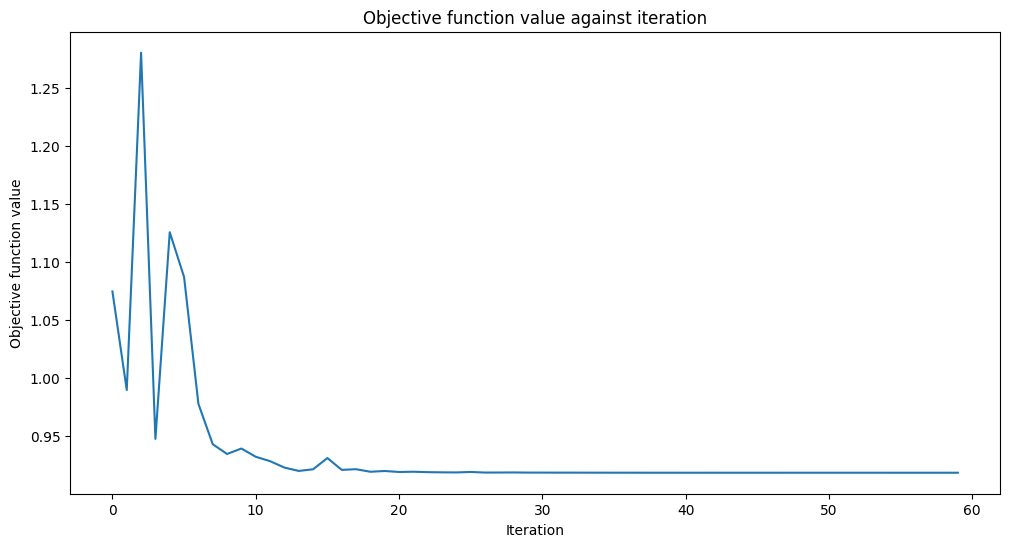

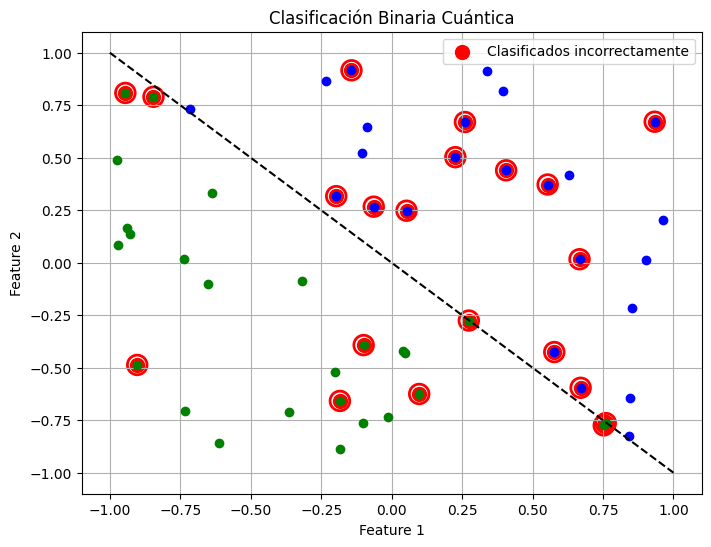

In [5]:
#Funcion callback que dibuja una grafica en vivo cuando llamamos al metodo .fit()
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#Creation and training of the Neural Network Classifier
with open('datos_entrenamiento_circuito3_50samples.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    #Write the header of the csv file
    writer.writerow(['Fecha', 'Hora', 'Tiempo de ejecución', 'Score', 'Librería'])

    for i in range(100):
        start = time.time()
        
        #Create a estimator for the QNN
        estimator_qnn = EstimatorQNN(
            circuit=qiskit_circuit, input_params=qiskit_circuit.parameters[:2], weight_params=qiskit_circuit.parameters[2:]
        )
    
        #QNN map data to the interval [-1, 1]
        estimator_qnn.forward(dataset.X_aux[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))
        
        #Create a classifier from the QNN
        estimator_classifier = NeuralNetworkClassifier(
            estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
        )
        
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        #Train the classifier
        estimator_classifier.fit(dataset.X_aux, dataset.y)
        
        plt.rcParams["figure.figsize"] = (6, 4)
        
        #Calculate the score of the classifier
        score = estimator_classifier.score(dataset.X_aux, dataset.y)
        
        misclassified_indices = []
        
        #Obtain the misclassified indices
        y_predict = estimator_classifier.predict(dataset.X_aux)
        for idx, (y_target, y_p) in enumerate(zip(dataset.y, y_predict)):
            if y_target != y_p:
                misclassified_indices.append(idx)
        
        #Plot the data
        plt.figure(figsize=(8, 6))
        for idx, (x, y_target, y_p) in enumerate(zip(dataset.X_aux, dataset.y, y_predict)):
            if y_target == 1:
                plt.plot(x[0], x[1], "bo")
            else:
                plt.plot(x[0], x[1], "go")
            if idx in misclassified_indices:
                plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
        
        #Plot misclassified points
        incorrectly_classified = dataset.X_aux[misclassified_indices]
        plt.scatter(incorrectly_classified[:, 0], incorrectly_classified[:, 1], c='red', s=100, label='Clasificados incorrectamente')
        
        plt.plot([-1, 1], [1, -1], "--", color="black")
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Clasificación Binaria Cuántica')
        plt.legend()
        plt.grid(True)
        plt.show()

        end = time.time()
        tiempo_ejecucion = end - start

        now = datetime.datetime.now()
        fecha = now.strftime("%Y-%m-%d")
        hora = now.strftime("%H:%M:%S")
        libreria = 'Qiskit - Neural Network Classifier'
        
        writer.writerow([fecha, hora, tiempo_ejecucion, score, libreria])
